In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1.8.1+cu101
True


device(type='cuda', index=0)

## 读取数据

In [2]:
# torchvision.datasets.ImageFolder() # 从分类的文件夹中创建dataset类型数据
root_dir = r"../小型CSV数据/weather_dataset"
if not os.path.isdir(root_dir):
    os.makedirs(root_dir)
    train_dir = os.path.join(root_dir, "train_dir")
    test_dir = os.path.join(root_dir, "test_dir")
    os.makedirs(train_dir)
    os.makedirs(test_dir)

In [3]:
weather_species = ["cloudy", "rain", "shine", "sunrise"]
for train_or_test in ["train_dir", "test_dir"]:
    for spec in weather_species:
        os.makedirs(os.path.join(root_dir, train_or_test, spec))

In [4]:
images_dir = r"../小型CSV数据/dataset2"
for i, img_name in enumerate(os.listdir(images_dir)):
    for spec in weather_species:
        if spec in img_name:
            source_dir = os.path.join(images_dir, img_name)
            if i%5 == 0:
                target_dir = os.path.join(root_dir, "test_dir", spec, img_name)
            else:
                target_dir = os.path.join(root_dir, "train_dir", spec, img_name)
            shutil.copy(source_dir, target_dir)

In [5]:
# 统计各个文件夹下数据多少
weather_species = ["cloudy", "rain", "shine", "sunrise"]
for train_or_test in ["train_dir", "test_dir"]:
    for spec in weather_species:
        print(train_or_test, spec, 
              len(os.listdir(os.path.join(root_dir, train_or_test, spec))))

train_dir cloudy 240
train_dir rain 172
train_dir shine 202
train_dir sunrise 286
test_dir cloudy 60
test_dir rain 43
test_dir shine 51
test_dir sunrise 71


In [6]:
from torchvision import transforms
transform_ops = transforms.Compose([
                           transforms.Resize(size=(96, 96)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_ops)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_ops)
train_dataset.classes, train_dataset.class_to_idx, len(train_dataset)

(['cloudy', 'rain', 'shine', 'sunrise'],
 {'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3},
 900)

In [8]:
traindata_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32,
                                               shuffle=True)
testdata_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=32)                                          

In [9]:
imgs, labels = next(iter(traindata_loader))
imgs.shape

torch.Size([32, 3, 96, 96])

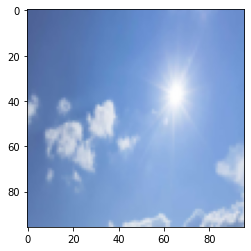

In [10]:
img = imgs[0].permute(1, 2, 0).numpy()
img = (img + 1)/ 2 # 由于Normalize的操作，所以需要将数据从-1到1的范围转换为[0, 1]
plt.imshow(img)

In [11]:
id_to_class = dict((v, k) for k, v in train_dataset.class_to_idx.items())
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

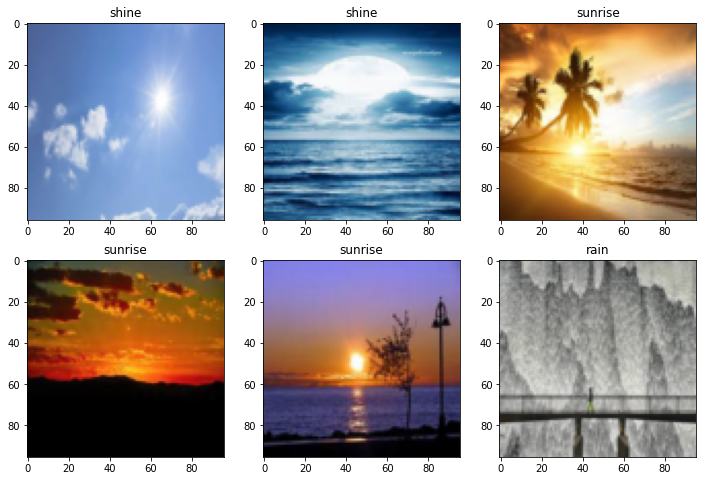

In [12]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(2, 3, i+1)
    plt.title(id_to_class[label.item()])
    plt.imshow(img)

## 创建模型

In [21]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.batch_norm1 = torch.nn.BatchNorm2d(num_features=16)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batch_norm2 = torch.nn.BatchNorm2d(num_features=32)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch_norm3 = torch.nn.BatchNorm2d(num_features=64)
        self.pool  = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1   = torch.nn.Linear(in_features=64*10*10, out_features=1024)
        self.batch_norm_fc = torch.nn.BatchNorm1d(num_features=1024)
        self.fc2   = torch.nn.Linear(in_features=1024, out_features=4)

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = self.batch_norm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batch_norm2(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.batch_norm3(x)
        
        x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        self.batch_norm_fc(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
learning_rate = 0.01
epochs = 30

def get_model():
    model = Model()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    return model, optimizer

model, optimizer = get_model()
model.to(device=device) # 将模型转移到GPU上进行训练
loss_func = torch.nn.CrossEntropyLoss()

## 创建训练代码

In [ ]:
# model.train() #训练模式
# model.eval() # 预测模式
# 这两句主要是会影响dropout层和batch_norm层

In [23]:
def fit(model, traindata_loader, testdata_loader, epoch):
    pred_corrected_num = 0
    total_num = 0
    training_batch_loss = 0
    model.train() # 由于存在dropout层，因此在训练和测试阶段是不同的效果的，因此使用model.train()来让模型知道接下来是在训练模式
    for x, y in traindata_loader:
        x, y = x.to(device), y.to(device) # 将数据转移到GPU上
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            pred_corrected_num += (y_pred == y).sum().item()
            total_num += y.shape[0]
            training_batch_loss += loss.item()
    epoch_accuracy = pred_corrected_num / total_num
    epoch_loss = training_batch_loss / len(traindata_loader.dataset)
    #---------------------------------------------------------------
    test_pred_corrected_num = 0
    test_total_num = 0
    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in testdata_loader:
            x, y = x.to(device), y.to(device) # 将数据转移到GPU上
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_pred_corrected_num += (y_pred == y).sum().item()
            test_total_num += y.shape[0]
            test_batch_loss += loss.item()
    test_accuracy = test_pred_corrected_num / test_total_num
    test_loss = test_batch_loss / len(testdata_loader.dataset)
    #---------------------------------------------------------------
    print("epoch = ", epoch, 
          "loss = ", round(epoch_loss, 3), 
          "accuracy = ", round(epoch_accuracy, 3),              
          "test_loss = ", round(test_loss, 3),
          "test_accuracy = ", round(test_accuracy, 3))
    return epoch_loss, epoch_accuracy, test_loss, test_accuracy

In [24]:
train_loss = []
train_accuracy = []
test_loss_ = []
test_accuracy_ = []

for epoch in range(epochs):
    epoch_loss, epoch_accuracy, test_loss, test_accuracy = fit(model, traindata_loader,
                                                               testdata_loader, epoch)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    test_loss_.append(test_loss)
    test_accuracy_.append(test_accuracy)

epoch =  0 loss =  0.375 accuracy =  0.638 test_loss =  0.629 test_accuracy =  0.662
epoch =  1 loss =  0.476 accuracy =  0.721 test_loss =  1.098 test_accuracy =  0.764
epoch =  2 loss =  0.235 accuracy =  0.699 test_loss =  1.259 test_accuracy =  0.649
epoch =  3 loss =  0.186 accuracy =  0.734 test_loss =  0.515 test_accuracy =  0.76
epoch =  4 loss =  0.065 accuracy =  0.708 test_loss =  0.067 test_accuracy =  0.764
epoch =  5 loss =  0.042 accuracy =  0.734 test_loss =  0.026 test_accuracy =  0.818
epoch =  6 loss =  0.029 accuracy =  0.732 test_loss =  0.065 test_accuracy =  0.809
epoch =  7 loss =  0.02 accuracy =  0.737 test_loss =  0.262 test_accuracy =  0.831
epoch =  8 loss =  0.027 accuracy =  0.754 test_loss =  0.019 test_accuracy =  0.747
epoch =  9 loss =  0.022 accuracy =  0.732 test_loss =  0.022 test_accuracy =  0.76
epoch =  10 loss =  0.019 accuracy =  0.76 test_loss =  0.02 test_accuracy =  0.818
epoch =  11 loss =  0.021 accuracy =  0.746 test_loss =  0.027 test_a

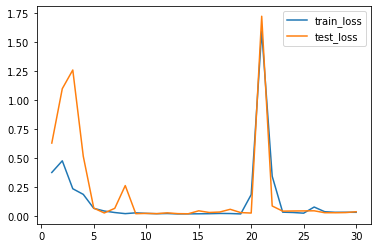

In [25]:
plt.plot(range(1, epochs+1), train_loss, label="train_loss")
plt.plot(range(1, epochs+1), test_loss_, label="test_loss")
plt.legend()

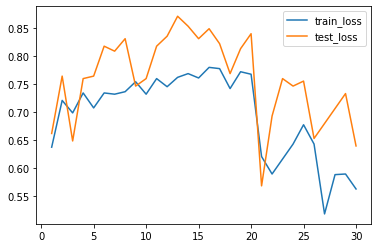

In [26]:
plt.plot(range(1, epochs+1), train_accuracy, label="train_loss")
plt.plot(range(1, epochs+1), test_accuracy_, label="test_loss")
plt.legend()